In [103]:
import numpy as numpy
import pandas as pd
from sklearn.utils import shuffle 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection  import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import re
import random
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline


# Reading csv file

In [104]:
df = pd.read_csv("TwitterSentimentAnalysis.csv", encoding='latin-1', header=None)

Shuffling the data in the data frame

In [105]:
df = df.sample(frac=1).reset_index(drop=True)

# Give column names

Assigning the Columns name to the data

In [106]:
df.columns = ["sentiment", "id", "date", "query", "user", "text"] 

In [107]:
df.columns

Index(['sentiment', 'id', 'date', 'query', 'user', 'text'], dtype='object')

Checking Null values in the dataset. Here we are counting each cloumn null values in the data set

In [108]:
df.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

Checking the duplicates values and counting duplicates in the data set

In [109]:
df.duplicated().sum()

0

get the first 5 rows from the dataframe

In [110]:
df.head(5)

,sentiment,id,date,query,user,text
0,0,1970718022,Sat May 30 04:57:57 PDT 2009,NO_QUERY,bunnykathedral,Gloria Capulet wants to play with her daughter...
1,4,1961379252,Fri May 29 09:24:46 PDT 2009,NO_QUERY,AmandaAutopsy,Coloring with Bianca in 3rd hour.
2,0,2014982500,Wed Jun 03 03:19:46 PDT 2009,NO_QUERY,AlexisAmoreFan,@alexisamore I slacked off with that for like...
3,4,2001425643,Tue Jun 02 00:50:43 PDT 2009,NO_QUERY,mysticaljane,Am in dire need of some Wings...have had plent...
4,0,2213905600,Wed Jun 17 16:00:19 PDT 2009,NO_QUERY,Bellamort_,"@Voldymort ooc: Dang it, and I missed you today!"


drop some column from the dataframe 

In [111]:
df = df.drop(["id", "date", "query", "user"], axis = 1) 

In [112]:
df.head(5)

,sentiment,text
0,0,Gloria Capulet wants to play with her daughter...
1,4,Coloring with Bianca in 3rd hour.
2,0,@alexisamore I slacked off with that for like...
3,4,Am in dire need of some Wings...have had plent...
4,0,"@Voldymort ooc: Dang it, and I missed you today!"


 count the number of sentiments with respect to their tweet (4 stands for positive tweet and 0 stands for negative tweet)

In [113]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64














# Cleaning data

add new column pre_clean_len to dataframe which is length of each tweet

In [114]:
df['pre_clean_len'] = [len(t) for t in df.text]

Finding outliers using Box plot using pre_clean_len column

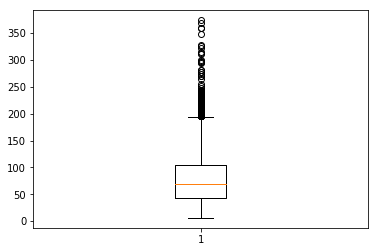

In [115]:
plt.boxplot(df.pre_clean_len)
plt.show()

check for any tweets greater than 140 characters

In [116]:
df[df.pre_clean_len > 140].head(10) 

,sentiment,text,pre_clean_len
182,4,"yayyyy &lt;3 cant sleep, on the phone with rya...",146
191,0,@Larissa_SG yes yes i have a few but they are ...,144
338,4,"So far, most Habbos would want to dance to &qu...",150
530,4,"@curiousillusion Shoes, VERY important. And re...",202
531,4,"lol, my mums got her music going. Its okay but...",146
576,4,@PhilBaumann I just woke up and I the first t...,144
754,4,http://twitpic.com/7haip - street meat(less) ...,141
980,0,Finding myself just sort of &quot;going throug...,146
985,4,Was in a hit &amp; run on the way to Brad &amp...,146
1034,0,@Wrestlevania if only it would work on my PC ...,146


At this stage, if you want you could remove these outlier tweets

# Cleaning operations

#Importing beautiful soup
#remove @ mentions from tweets
#remove URLs from tweets
#converting words like isn't to is not
#get only text from the tweets 
#converting all into lower case
#will replace non-alphabetic characters by space
#removing stopwords
#join the words

In [117]:
pat1 = r'@[A-Za-z0-9_]+'        # remove @ mentions from tweets
pat2 = r'https?://[^ ]+'        # remove URLs from tweets
combined_pat = r'|'.join((pat1, pat2)) #addition of pat1 and pat2
www_pat = r'www.[^ ]+'         # remove URLs from tweets
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",\
                 "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",\
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",\
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",\
                "mustn't":"must not"}
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",\
            'won', "won't", 'wouldn', "wouldn't"])
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):  # define tweet_cleaner function to clean the tweets
    soup = BeautifulSoup(text, 'lxml')    # create beautiful soup object
    souped = soup.get_text()   # get only text from the tweets 
    bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed) # calling combined_pat
    stripped = re.sub(www_pat, '', stripped) #remove URLs
    lower_case = stripped.lower()      # converting all into lower case
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case) # converting words like isn't to is not
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)       # will replace # by space
    words = [x for x  in word_tokenize(letters_only) if len(x) > 1] # Word Punct Tokenize and only consider words whose length is greater than 1
    return (" ".join(l for l in words if l not in stopwords)).strip() # join the words

In [118]:
#we have 1600000 instances. But processing so many instances will take a very very long time.
#Hence, restricting to rather 50000 instances.
limit=50000
import time; 
ms = time.time()
#nums = [0,400000,800000,1200000,1600000] # used for batch processing tweets
#nums = [0, 9999]
clean_tweet_texts = [] # initialize list
for i in range(0,limit): # batch process 1.6 million tweets 
    if i % 10000==0:
        print(i, time.time()-ms)
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))  # call tweet_cleaner function and pass parameter as all the tweets to clean the tweets and append cleaned tweets into clean_tweet_texts list

0 0.0019421577453613281
10000 7.568846225738525
20000 15.01684856414795
30000 22.38850736618042
40000 29.43859553337097


# clean_tweet_texts

In [119]:
clean_tweet_texts[:10]

['gloria capulet wants play daughter oh juliet miss shakespeare usuals',
 'coloring bianca rd hour',
 'slacked like weeks busy',
 'dire need wings plenty red bull still no lift opposite affect keeps grouned',
 'ooc dang missed today',
 'delicious red almost gone though',
 'yesterday sunny today raining',
 'pudding pops mmmmm makes want ice cream know makes no sense lol',
 'hard time finding xl turtle shirt love mugs though',
 'guess need leave warm comfort bed taking mom shops quick morning head killing ffs']

tokenize word in clean_tweet_texts and append it to word_tokens list

In [120]:
word_tokens = [] # initialize list for tokens
for word in clean_tweet_texts:  # for each word in clean_tweet_texts
    word_tokens.append(word_tokenize(word)) #tokenize word in clean_tweet_texts and append it to word_tokens list

In [121]:
word_tokens[:10]

[['gloria',
  'capulet',
  'wants',
  'play',
  'daughter',
  'oh',
  'juliet',
  'miss',
  'shakespeare',
  'usuals'],
 ['coloring', 'bianca', 'rd', 'hour'],
 ['slacked', 'like', 'weeks', 'busy'],
 ['dire',
  'need',
  'wings',
  'plenty',
  'red',
  'bull',
  'still',
  'no',
  'lift',
  'opposite',
  'affect',
  'keeps',
  'grouned'],
 ['ooc', 'dang', 'missed', 'today'],
 ['delicious', 'red', 'almost', 'gone', 'though'],
 ['yesterday', 'sunny', 'today', 'raining'],
 ['pudding',
  'pops',
  'mmmmm',
  'makes',
  'want',
  'ice',
  'cream',
  'know',
  'makes',
  'no',
  'sense',
  'lol'],
 ['hard',
  'time',
  'finding',
  'xl',
  'turtle',
  'shirt',
  'love',
  'mugs',
  'though'],
 ['guess',
  'need',
  'leave',
  'warm',
  'comfort',
  'bed',
  'taking',
  'mom',
  'shops',
  'quick',
  'morning',
  'head',
  'killing',
  'ffs']]

# Lemmatizing

In [122]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/yaswanth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [123]:
df1 = [] # initialize list df1 to store words after lemmatization
lemmatizer = WordNetLemmatizer() # create an object of WordNetLemmatizer
for l in word_tokens: # for loop for every tokens in word_token
    b = [lemmatizer.lemmatize(q) for q in l] #for every tokens in word_token lemmatize word and giev it to b
    df1.append(b) #append b to list df1

# df

In [124]:
clean_df1 =[] # initialize list clean_df1 to join word tokens after lemmatization
for c in df1:  # for loop for each list in df1
    a = " ".join(c) # join words in list with space in between and give it to a
    clean_df1.append(a) # append a to clean_df1

# clean_df1

convert clean_tweet_texts into dataframe and name it as clean_df

In [125]:
clean_df = pd.DataFrame(clean_df1,columns=['text']) # convert clean_tweet_texts into dataframe and name it as clean_df

In [126]:
clean_df['clean_len'] = [len(t) for t in clean_df.text] # Again make a new coloumn in the dataframe and name it as clean_len which 

In [127]:
clean_df[clean_df.clean_len > 140].head(10) # again check if any tweet is more than 140 characters

,text,clean_len


In [128]:
target2 = [] # initialize list
for i in range(0,limit): # batch process 1.6 million tweets 
    target2.append(df['sentiment'][i])
clean_df['target']=target2
clean_df.head()

,text,clean_len,target
0,gloria capulet want play daughter oh juliet mi...,67,0
1,coloring bianca rd hour,23,4
2,slacked like week busy,22,0
3,dire need wing plenty red bull still no lift o...,73,4
4,ooc dang missed today,21,0


In [129]:
X = clean_df.text # get all the text in x variable
y = clean_df.target # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y
clean_df['target'].value_counts()

(50000,)
(50000,)


4    25016
0    24984
Name: target, dtype: int64

# perform train and test split

X_train is the tweets of training data, X_test is the testing tweets which we have to predict, y_train is the sentiments of tweets in the traing data and y_test is the sentiments of the tweets  which we will use to measure the accuracy of the model

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1) # split the data into traing and testing set where ratio is 80:20

### Bag of words

In [131]:
count_vect = CountVectorizer()
count_vect.fit(X_train)
x_train_bow = count_vect.transform(X_train)
x_test_bow = count_vect.transform(X_test)

### TFIDF

In [132]:
tf = TfidfVectorizer(ngram_range=(1,2))
tf.fit(X_train) 
x_train_tf = tf.transform(X_train) 
x_test_tf = tf.transform(X_test) 

### Modeling

In [133]:
alpha=[1e-1,1,10]
param_grid = {'alpha':alpha}
nb= GridSearchCV(MultinomialNB(), param_grid,cv=10)

### naive bayes for bag of words

In [134]:
nb.fit(x_train_bow,y_train)
nb.best_params_

{'alpha': 10}

In [135]:
y_pred_nb = nb.predict(x_test_bow) 
metrics.accuracy_score(y_test, y_pred_nb)

0.7498

In [136]:
confusion_matrix(y_test, y_pred_nb)

array([[4127,  864],
       [1638, 3371]])

0.831595374369013


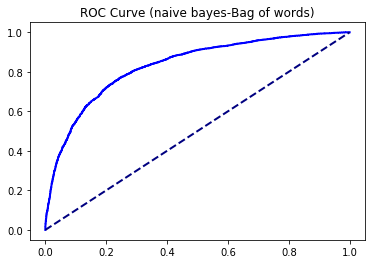

In [137]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
y1=y_test.copy()
y1.loc[y1==4]=1
y_pred_proba = nb.predict_proba(x_test_bow)[:,1]
fpr, tpr, thresholds = roc_curve(y1, y_pred_proba)

roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.title("ROC Curve (naive bayes-Bag of words)")
plt.plot(fpr, tpr, color='blue',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

### naive bayes for tfidf

In [138]:
nb.fit(x_train_tf,y_train)
nb.best_params_

{'alpha': 1}

In [139]:
y_pred_nb = nb.predict(x_test_tf) 
metrics.accuracy_score(y_test, y_pred_nb)

0.7555

In [140]:
confusion_matrix(y_test, y_pred_nb)

array([[4000,  991],
       [1454, 3555]])

0.8416329468907479


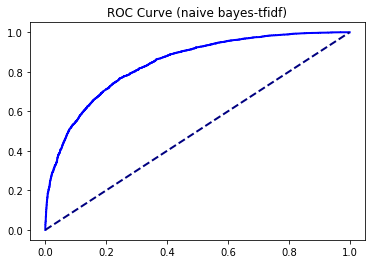

In [141]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
y1=y_test.copy()
y1.loc[y1==4]=1
y_pred_proba = nb.predict_proba(x_test_tf)[:,1]
fpr, tpr, thresholds = roc_curve(y1, y_pred_proba)

roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.title("ROC Curve (naive bayes-tfidf)")
plt.plot(fpr, tpr, color='blue',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

In [142]:
param_grid = {'C': [0.1, 1] ,'penalty' : ['l1', 'l2']}
lr= GridSearchCV(LogisticRegression(), param_grid,cv=10)

### logistic regression for bag of words

In [143]:
lr.fit(x_train_bow, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [144]:
lr.best_params_

{'C': 1, 'penalty': 'l1'}

In [145]:
# Prediction
y_pred = lr.predict(x_test_bow)
# Accuracy metrics
print("accuracy:", metrics.accuracy_score(y_test, y_pred))
# Confusion Matrix
confusion_matrix(y_test, y_pred)

accuracy: 0.7612


array([[3661, 1330],
       [1058, 3951]])

0.8314245338154895


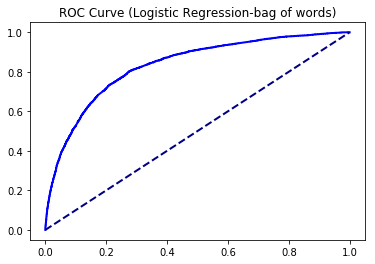

In [146]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
y1=y_test.copy()
y1.loc[y1==4]=1
y_pred_proba = lr.predict_proba(x_test_bow)[:,1]
fpr, tpr, thresholds = roc_curve(y1, y_pred_proba)

roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.title("ROC Curve (Logistic Regression-bag of words)")
plt.plot(fpr, tpr, color='blue',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()



### logistic regression for tfidf

In [147]:
lr.fit(x_train_tf, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [148]:
lr.best_params_

{'C': 1, 'penalty': 'l2'}

In [149]:
# Prediction
y_pred = lr.predict(x_test_tf)
# Accuracy metrics
print("accuracy:", metrics.accuracy_score(y_test, y_pred))
# Confusion Matrix
confusion_matrix(y_test, y_pred)

accuracy: 0.7739


array([[3919, 1072],
       [1189, 3820]])

0.8483510886575272


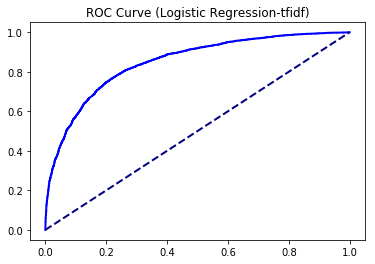

In [150]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
y1=y_test.copy()
y1.loc[y1==4]=1
y_pred_proba = lr.predict_proba(x_test_tf)[:,1]
fpr, tpr, thresholds = roc_curve(y1, y_pred_proba)

roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.title("ROC Curve (Logistic Regression-tfidf)")
plt.plot(fpr, tpr, color='blue',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()



In [153]:
import joblib
joblib.dump(tf, 'tf_vect.pkl')
joblib.dump(lr, 'lr.pkl')

['lr.pkl']